# Roman Pottery Project Classifying Mining Locations

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


##### Read in Data and look at it

In [83]:
raw_data = pd.read_csv("ecologyStamps/data/stamps.csv",delimiter=';')
print(raw_data)

               X          Y     id        lat       long                 type  \
0      -0.580500  44.840439   7326  -0.580500  44.840439          Oberaden 74   
1       2.174100  41.398371  33256   2.174100  41.398371  Dressel 2-4 Catalan   
2       4.032143  46.926780  20958   4.032143  46.926780            Dressel 1   
3      -3.983333  55.950000  16637  -3.983333  55.950000           Dressel 20   
4      11.883333  45.416667  33025  11.883333  45.416667           Dressel 6B   
...          ...        ...    ...        ...        ...                  ...   
24087   4.942851  43.383543   9873   4.942851  43.383543           Dressel 1B   
24088   2.762884  42.087759   9313   2.762884  42.087759               Tegula   
24089  -0.093145  51.514248  15852  -0.093145  51.514248           Dressel 20   
24090   4.300357  46.954878   4878   4.300357  46.954878             Gauloise   
24091   6.866667  43.433333   9356   6.866667  43.433333  Dressel 2-4 Catalan   

               site        

##### Notice that X and Y are the same as latitude and longitude. Also notice they are flipped.
+ X is associated with longitude. We need to fix the dataset.
+ First we will drop X and Y, and switch the column names 

In [84]:
raw_data = raw_data.drop(['X','Y'],axis=1)
raw_data['lat'], raw_data['long'] = raw_data['long'], raw_data['lat']
print(raw_data)

          id        lat       long                 type          site  \
0       7326  44.840439  -0.580500          Oberaden 74      Bordeaux   
1      33256  41.398371   2.174100  Dressel 2-4 Catalan     Barcelona   
2      20958  46.926780   4.032143            Dressel 1  Mont-Beuvray   
3      16637  55.950000  -3.983333           Dressel 20   Cumbernauld   
4      33025  45.416667  11.883333           Dressel 6B        Padova   
...      ...        ...        ...                  ...           ...   
24087   9873  43.383543   4.942851           Dressel 1B  Golfe de Fos   
24088   9313  42.087759   2.762884               Tegula         Camós   
24089  15852  51.514248  -0.093145           Dressel 20        London   
24090   4878  46.954878   4.300357             Gauloise         Autun   
24091   9356  43.433333   6.866667  Dressel 2-4 Catalan   Rade d'Agay   

             code           name  
0      PHILODAMVS      Aquitania  
1               O  Tarraconensis  
2             SIN 

##### Lets check how many unique categories are in each of these features

In [85]:
for col_name in raw_data.columns:
    obs_per_cat = raw_data[col_name].value_counts().head(20)
    print(obs_per_cat)

id
33307    5
36298    5
36284    5
17839    3
36494    3
36489    3
36472    3
36535    3
36349    3
36485    3
4714     3
36347    3
36486    3
36601    3
36484    3
36637    3
17356    3
8306     3
39191    3
36537    3
Name: count, dtype: int64
lat
40.633333    2060
40.683333    1867
41.750000     652
46.926780     491
43.383543     473
45.416667     444
49.984188     427
45.748457     427
45.524785     404
43.184417     397
51.514248     369
37.542203     339
41.396145     336
37.658961     311
47.536818     279
37.615058     275
54.966667     270
41.447145     260
51.833333     217
42.139543     212
Name: count, dtype: int64
long
 17.933333    2059
 17.850000    1867
 12.283333     645
 4.032143      491
 4.942851      473
 11.883333     454
 4.846711      427
 8.279096      427
 4.873453      404
 3.008816      397
-0.093145      369
-5.082599      339
 2.007994      336
-5.527510      311
 7.717205      279
-5.666942      275
 2.244789      260
 3.117809      212
 29.955266    

##### Let's look at the names column since that is the variable we will be trying to predict.
* Belgica only has 487 and it only goes down from there with remaining areas. Let's remove them and reevaluate
* We are removing them because only 7 of the regions contain nearly all the pottery.

In [86]:
N = 7
top_seven_names = raw_data['name'].value_counts().nlargest(N).index.to_list()
print(top_seven_names)
mask = raw_data['name'].isin(top_seven_names)
filtered_data = raw_data[mask].copy()
filtered_data = filtered_data.reset_index(drop=True, inplace=False)
print(filtered_data)

['Italia', 'Narbonensis', 'Tarraconensis', 'Germania Superior', 'Britannia', 'Baetica', 'Lugdunensis']
          id        lat       long                 type          site  \
0      33256  41.398371   2.174100  Dressel 2-4 Catalan     Barcelona   
1      20958  46.926780   4.032143            Dressel 1  Mont-Beuvray   
2      33025  45.416667  11.883333           Dressel 6B        Padova   
3      16590  51.733333  -1.983333           Dressel 20   Cirencester   
4      40133  40.633333  17.933333   Brindisian amphora      Brindisi   
...      ...        ...        ...                  ...           ...   
20438   9873  43.383543   4.942851           Dressel 1B  Golfe de Fos   
20439   9313  42.087759   2.762884               Tegula         Camós   
20440  15852  51.514248  -0.093145           Dressel 20        London   
20441   4878  46.954878   4.300357             Gauloise         Autun   
20442   9356  43.433333   6.866667  Dressel 2-4 Catalan   Rade d'Agay   

             code   

##### Still have 20443 rows which confirms most of the samples came from the 7 previously looked at regions

+ Going to check the remaining features and see how diverse those categories are
+ Might be helpful if we use visuals to gain some perspective on the data

In [87]:
for col_name in filtered_data.columns:
    obs_per_cat = filtered_data[col_name].value_counts().head(20)
    print(obs_per_cat)

id
33307    5
36298    5
36284    5
36602    3
33308    3
36535    3
36484    3
36347    3
17356    3
21588    3
36637    3
36285    3
8306     3
36411    3
11       3
19470    3
19339    3
36537    3
17610    3
36560    3
Name: count, dtype: int64
lat
40.633333    2060
40.683333    1867
41.750000     652
46.926780     491
43.383543     473
45.416667     444
49.984188     427
45.748457     427
45.524785     404
43.184417     397
51.514248     369
37.542203     339
41.396145     336
37.658961     311
47.536818     279
37.615058     275
54.966667     270
41.447145     260
42.139543     212
42.500000     178
Name: count, dtype: int64
long
 17.933333    2059
 17.850000    1867
 12.283333     645
 4.032143      491
 4.942851      473
 11.883333     454
 4.846711      427
 8.279096      427
 4.873453      404
 3.008816      397
-0.093145      369
-5.082599      339
 2.007994      336
-5.527510      311
 7.717205      279
-5.666942      275
 2.244789      260
 3.117809      212
 11.250000    

##### Breakdown of features:
* ID - isn't going to help here, remove
* Lat, Long - is most likely going to be leaking the answer into the response, so we will remove
* Type - Dressel20 and Brindisian Amphora appear to account for over half the types
* Site - Brindisi and Canale Giancola account for over half the sites
* Code - Still unbalanced but not as extreme. Viselli has the most stamps on the pottery.

##### Going to Produce cross tabs to get a visual understanding of what is going on


--- Generating Heatmap for Top 5 Types vs Top 7 Regions ---


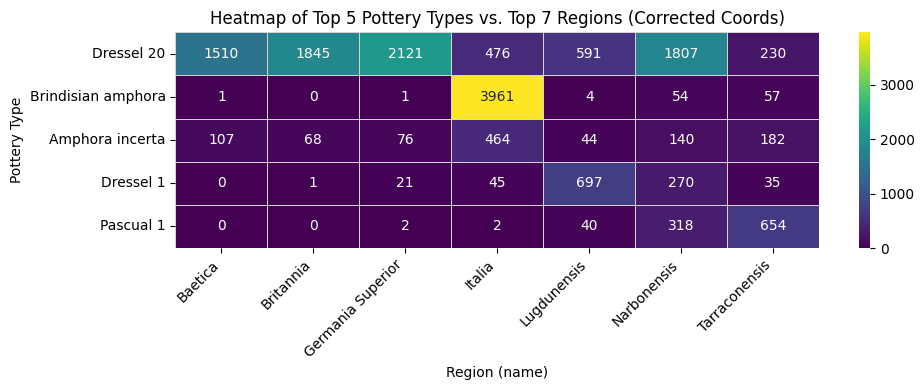

In [88]:
# --- Heatmap for Top 5 Types vs Top 7 Regions (No Data Alteration) ---
print("\n--- Generating Heatmap for Top 5 Types vs Top 7 Regions ---")

df_for_heatmap = filtered_data
row_var = 'type'
col_var = 'name'
N_TOP_ROWS = 5 # <<< Display only Top 5 Types >>>

top_n_types = df_for_heatmap[row_var].value_counts().nlargest(N_TOP_ROWS).index.tolist()
full_crosstab_table = pd.crosstab(df_for_heatmap[row_var], df_for_heatmap[col_var])
rows_to_plot = [t for t in top_n_types if t in full_crosstab_table.index]
crosstab_filtered_for_plot = full_crosstab_table.loc[rows_to_plot]

plt.figure(figsize=(10, 4))
sns.heatmap(
    crosstab_filtered_for_plot,
    annot=True,       
    fmt="d",          
    cmap="viridis",   
    linewidths=.5,
    linecolor='lightgray'
)
plt.title(f'Heatmap of Top {N_TOP_ROWS} Pottery Types vs. Top 7 Regions (Corrected Coords)')
plt.xlabel('Region (name)')
plt.ylabel('Pottery Type')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### Dressel 20 is spread out through the regions. It should be a good choice for our scenario test

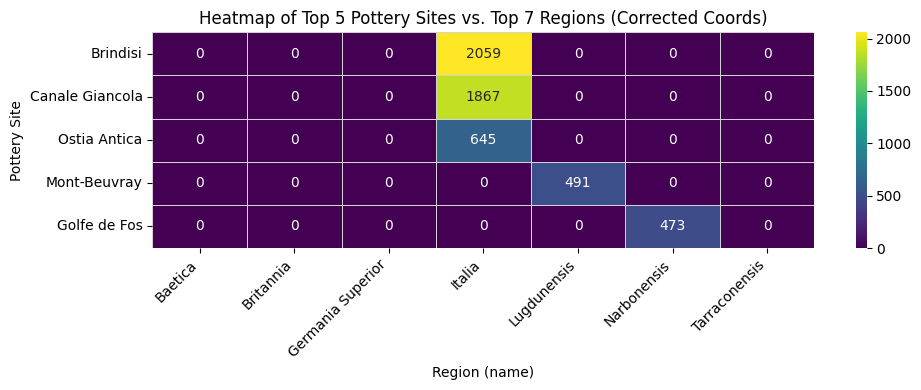

In [89]:
# --- Heatmap for Top 5 Sites vs Top 7 Regions (No Data Alteration) ---

df_for_heatmap = filtered_data
row_var = 'site'
col_var = 'name'

top_n_types = df_for_heatmap[row_var].value_counts().nlargest(N_TOP_ROWS).index.tolist()
full_crosstab_table = pd.crosstab(df_for_heatmap[row_var], df_for_heatmap[col_var])
rows_to_plot = [t for t in top_n_types if t in full_crosstab_table.index]

crosstab_filtered_for_plot = full_crosstab_table.loc[rows_to_plot]

plt.figure(figsize=(10, 4)) 
sns.heatmap(
    crosstab_filtered_for_plot,
    annot=True,       
    fmt="d",          
    cmap="viridis",
    linewidths=.5,
    linecolor='lightgray'
)
plt.title(f'Heatmap of Top {N_TOP_ROWS} Pottery Sites vs. Top 7 Regions (Corrected Coords)')
plt.xlabel('Region (name)')
plt.ylabel('Pottery Site')
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.tight_layout() 
plt.show()


##### Italia has 3 sites. Brindisi and Canale Giancola being the two largest. Ostia Antica was the 3rd largest dig site.

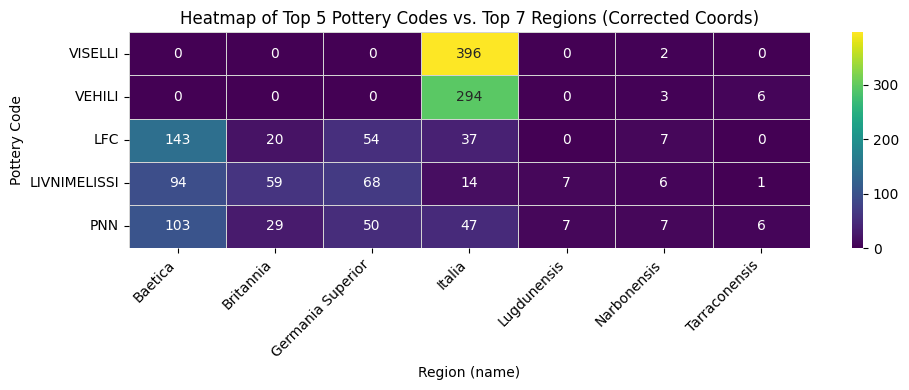

In [90]:

df_for_heatmap = filtered_data
row_var = 'code'
col_var = 'name'

top_n_types = df_for_heatmap[row_var].value_counts().nlargest(N_TOP_ROWS).index.tolist()
full_crosstab_table = pd.crosstab(df_for_heatmap[row_var], df_for_heatmap[col_var])
rows_to_plot = [t for t in top_n_types if t in full_crosstab_table.index]
crosstab_filtered_for_plot = full_crosstab_table.loc[rows_to_plot]


plt.figure(figsize=(10, 4))
sns.heatmap(
    crosstab_filtered_for_plot,
    annot=True,       
    fmt="d",          
    cmap="viridis",
    linewidths=.5,
    linecolor='lightgray'
)
plt.title(f'Heatmap of Top {N_TOP_ROWS} Pottery Codes vs. Top 7 Regions (Corrected Coords)')
plt.xlabel('Region (name)')
plt.ylabel('Pottery Code')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()


##### VISELLI and VEHILI are the signatures stamped into the pottery. Which means there were two big producers of pottery in Italia and they created nearly all of it

##### Below is the preprocessing and modeling pipeline:
* LE is the label ecoder for the response
* OneHotEncoder will be for turning the categorical features into integers for the classification models
* Column transformer is used to transform individual columns
* pipeline does each process step-by-step
##### We have 3 different pipelines for each model. They will be compared by accuracy and a final test run will use f1 scores

In [91]:
LE = LabelEncoder()
y = filtered_data['name']
y = LE.fit_transform(y)

features = ['type','site','code']
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[('cat', encoder, features)],remainder='drop')

X = filtered_data.drop(['name','id','lat','long'],axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,shuffle=True,stratify=y,random_state=4192025)
pipeline_LR_unweighted = Pipeline(steps=[
    ('preprocessing', preprocessor), # Step 1: Apply the ColumnTransformer
    ('LR_unweighted', LogisticRegression(random_state=4192025)),
])

pipeline_LR_weighted = Pipeline(steps=[
    ('preprocessing', preprocessor), # Step 1: Apply the ColumnTransformer
    ('LR_weighted', LogisticRegression(random_state=4192025, class_weight="balanced")),
])

pipeline_RF = Pipeline(steps=[
    ('preprocessing', preprocessor), # Step 1: Apply the ColumnTransformer
    ('RF', RandomForestClassifier(random_state=4192025)),
])


In [92]:


pipeline_LR_weighted.fit(X_train,y_train)
pipeline_LR_unweighted.fit(X_train,y_train)
pipeline_RF.fit(X_train,y_train)

y_preds_lr_weighted = pipeline_LR_weighted.predict(X_train)
y_preds_lr_unweighted = pipeline_LR_unweighted.predict(X_train)
y_preds_rf = pipeline_RF.predict(X_train)

LR_unweighted_score = accuracy_score(y_train, y_preds_lr_unweighted)
LR_weighted_score = accuracy_score(y_train, y_preds_lr_weighted)
RF_score = accuracy_score(y_train, y_preds_rf)

print(f"the unweighted logistic Regression is : {LR_unweighted_score}, lr weighted is : {LR_weighted_score}, Random Forest is :{RF_score}")


the unweighted logistic Regression is : 0.9961477314418491, lr weighted is : 0.9959031429619665, Random Forest is :0.9996942644001467


##### The training scores for each model is roughly between 99.5% and 99.9% accuracy

##### Test set outputs are between 97.2% and 98.4% which indicates slight overfit but acceptable

In [101]:

y_preds_lr_weighted = pipeline_LR_weighted.predict(X_test)
y_preds_lr_unweighted = pipeline_LR_unweighted.predict(X_test)
y_preds_rf = pipeline_RF.predict(X_test)

LR_unweighted_score = accuracy_score(y_test, y_preds_lr_unweighted)
LR_weighted_score = accuracy_score(y_test, y_preds_lr_weighted)
RF_score = accuracy_score(y_test, y_preds_rf)

LR_unweighted_f1 = f1_score(y_test, y_preds_lr_unweighted, average='weighted')
LR_weighted_f1 = f1_score(y_test, y_preds_lr_weighted, average='weighted')
RF_f1 = f1_score(y_test, y_preds_rf, average='weighted')

print(f"the unweighted logistic Regression is : {LR_unweighted_score}, lr weighted is : {LR_weighted_score}, Random Forest is :{RF_score}")
print(f"f1 scores for the unweighted LR: {LR_unweighted_f1}, weighted LR: {LR_weighted_f1}, RF: {RF_f1}")

the unweighted logistic Regression is : 0.9841036928344339, lr weighted is : 0.9823917828319882, Random Forest is :0.9728539985326485
f1 scores for the unweighted LR: 0.9841163687590359, weighted LR: 0.9824457308989278, RF: 0.9728609415165851


##### Next is the scenario, lets pick a place in London and some pottery
* Scenario Defined:Type='Dressel 20', Site='Ostia Antica', Code='VISELLI'

##### For the model we will choose the unweighted Logisitic Regression model. It had the least overfit

##### Results were it choose the correct region(Italia)


In [100]:
scenario = pd.DataFrame([{'type' :'Dressel 20', 'site' : 'Ostia Antica', 'code':'VISELLI', 'name' : 'Italia' }])
features_for_prediction = ['type','site','code']
X_scenario = scenario[features_for_prediction]
y_pred_encoded = pipeline_LR_unweighted.predict(X_scenario)

y_scenario = LE.transform(scenario['name'])
prediction = y_scenario==y_pred_encoded

print(f"Did we correctly predict the scenario? {'Yes!' if prediction else 'No' }")

Did we correctly predict the scenario? Yes!
